<a href="https://colab.research.google.com/github/JorgeGuiller/MachineLearning/blob/main/hw4_gonzales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github link:

In [30]:
import os
from email import policy
from email.parser import BytesParser
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import re
import matplotlib.pyplot as plt


#  Load stop words from a file
def load_stop_words(stop_words_file):
    with open(stop_words_file, 'r') as file:
        stop_words = set(file.read().split())
    return stop_words

#  Preprocess email content (remove alphanumeric characters, punctuation, and stop words)
def preprocess_email_content(content, stop_words):
    content = content.lower()
    content = re.sub(r'[^a-z\s]', '', content)  # Remove punctuation, non-alphabetic characters
    words = content.split()  # Split into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return words

#  Build vocabulary and count word frequencies manually
def build_vocabulary(emails, top_n_words=10000):
    word_freq = {}  # Initialize an empty dictionary for word frequencies
    for email in emails:
        for word in email:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1

    # Sort words by frequency and keep the top N words
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    vocabulary = [word for word, _ in sorted_words[:top_n_words]]

    return vocabulary

#  Create feature matrix from the emails
def create_feature_matrix(emails, vocabulary):
    features = np.zeros((len(emails), len(vocabulary)))
    for i, email in enumerate(emails):
        email_word_count = {word: email.count(word) for word in email}
        for j, word in enumerate(vocabulary):
            features[i, j] = email_word_count.get(word, 0)  # Get word count if exists, else 0
    return features

#  Calculate priors for spam and ham
def calculate_priors(labels):
    num_spam = sum(labels)
    num_ham = len(labels) - num_spam
    prior_ham = num_ham / len(labels)
    prior_spam = num_spam / len(labels)
    return prior_ham, prior_spam

#  Estimate likelihoods with Laplace smoothing
def estimate_likelihoods(X, y, vocab_size, alpha=1.0):
    spam_likelihood = np.zeros(vocab_size)
    ham_likelihood = np.zeros(vocab_size)

    spam_word_counts = np.sum(X[y == 1], axis=0)
    ham_word_counts = np.sum(X[y == 0], axis=0)

    spam_likelihood = (spam_word_counts + alpha) / (np.sum(spam_word_counts) + alpha * vocab_size)
    ham_likelihood = (ham_word_counts + alpha) / (np.sum(ham_word_counts) + alpha * vocab_size)

    return ham_likelihood, spam_likelihood

#  Classify new emails using Naive Bayes rule
def classify_email(email_features, ham_likelihood, spam_likelihood, prior_ham, prior_spam):
    log_prob_spam = np.sum(email_features * np.log(spam_likelihood)) + np.log(prior_spam)
    log_prob_ham = np.sum(email_features * np.log(ham_likelihood)) + np.log(prior_ham)
    return 1 if log_prob_spam > log_prob_ham else 0

#  Evaluate classifier performance
def evaluate_classifier(y_true, y_pred):
    TP = sum((y_true[i] == 1 and y_pred[i] == 1) for i in range(len(y_true)))  # True Positives
    TN = sum((y_true[i] == 0 and y_pred[i] == 0) for i in range(len(y_true)))  # True Negatives
    FP = sum((y_true[i] == 0 and y_pred[i] == 1) for i in range(len(y_true)))  # False Positives
    FN = sum((y_true[i] == 1 and y_pred[i] == 0) for i in range(len(y_true)))  # False Negatives

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1

#  Function to load an email
def load_email(filepath):
    try:
        with open(filepath, 'rb') as file:
            email = BytesParser(policy=policy.default).parse(file)
            if email:
                return email
            else:
                print(f"Warning: No content found in email: {filepath}")
                return None
    except Exception as e:
        print(f"Error parsing email at {filepath}: {e}")
        return None

#  Process a chunk of emails
def process_emails(email_paths):
    contents = []
    for path in email_paths:
        email_content = load_email(path)
        if email_content:
            contents.append(email_content)
    return contents

#  Main processing function for emails in a directory
def main(email_directory):
    email_paths = [os.path.join(email_directory, fname) for fname in os.listdir(email_directory)]

    if not email_paths:
        print(f"No email files found in the directory: {email_directory}")
        return []

    with ProcessPoolExecutor() as executor:
        chunk_size = len(email_paths) // os.cpu_count() + 1
        chunks = [email_paths[i:i + chunk_size] for i in range(0, len(email_paths), chunk_size)]
        results = list(executor.map(process_emails, chunks))

    all_contents = [content for sublist in results for content in sublist]
    return all_contents

#  Load labels and email paths from the label file
def load_labels(label_file):
    train_ham_emails = []
    train_spam_emails = []
    test_ham_emails = []
    test_spam_emails = []

    with open(label_file, 'r') as file:
        for line in file:
            label, email_path = line.strip().split()
            email_path = email_path.replace('../', '/content/drive/MyDrive/MP3/')

            if label == 'ham' and int(email_path.split('/')[-2]) <= 70:
                train_ham_emails.append(email_path)
            elif label == 'spam' and int(email_path.split('/')[-2]) <= 70:
                train_spam_emails.append(email_path)
            elif label == 'ham' and int(email_path.split('/')[-2]) > 70:
                test_ham_emails.append(email_path)
            elif label == 'spam' and int(email_path.split('/')[-2]) > 70:
                test_spam_emails.append(email_path)

    return train_ham_emails, train_spam_emails, test_ham_emails, test_spam_emails

#  Train Naive Bayes classifier
def train_naive_bayes(emails, labels, stop_words, top_n_words=10000, alpha=1.0):
    preprocessed_emails = [preprocess_email_content(email, stop_words) for email in emails]

    # Manually build the vocabulary by counting word frequencies
    vocabulary = build_vocabulary(preprocessed_emails, top_n_words)

    X = create_feature_matrix(preprocessed_emails, vocabulary)
    prior_ham, prior_spam = calculate_priors(labels)
    ham_likelihood, spam_likelihood = estimate_likelihoods(X, np.array(labels), len(vocabulary), alpha)

    return vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam

#  Test Naive Bayes classifier
def test_naive_bayes(emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words):
    preprocessed_emails = [preprocess_email_content(email, stop_words) for email in emails]
    X_test = create_feature_matrix(preprocessed_emails, vocabulary)

    predictions = []
    for email_features in X_test:
        predictions.append(classify_email(email_features, ham_likelihood, spam_likelihood, prior_ham, prior_spam))

    return predictions

#  Main program to run the complete Naive Bayes process
def main_program():
    label_file_path = '/content/drive/MyDrive/MP3/labels'
    stop_words_file = '/content/drive/MyDrive/MP3/stop_words.txt'  # Path to stop words file
    stop_words = load_stop_words(stop_words_file)

    # Load train and test labels
    train_ham_email_paths, train_spam_email_paths, test_ham_email_paths, test_spam_email_paths = load_labels(label_file_path)

    # Combine ham and spam for training
    train_emails = train_ham_email_paths + train_spam_email_paths
    train_labels = [0] * len(train_ham_email_paths) + [1] * len(train_spam_email_paths)
    print('Total amount of train emails:', len(train_emails))


    # Combine ham and spam for testing
    test_emails = test_ham_email_paths + test_spam_email_paths
    test_labels = [0] * len(test_ham_email_paths) + [1] * len(test_spam_email_paths)
    print('Total amount test emails:', len(test_emails))
    # Train the Naive Bayes classifier
    vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam = train_naive_bayes(train_emails, train_labels, stop_words)

    # Test the classifier
    y_pred = test_naive_bayes(test_emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words)

    # Evaluate the classifier
    accuracy, precision, recall, f1 = evaluate_classifier(test_labels, y_pred)
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

main_program()


Total amount of train emails: 21300
Total amount test emails: 16522
Accuracy: 0.67, Precision: 0.67, Recall: 1.00, F1 Score: 0.81


Total amount of train emails: 21300
Total amount test emails: 16522

Effect of Stop Words Removal on Performance:
Metric         With Stop Words     Without Stop Words  
Accuracy       0.6739              0.6739              
Precision      0.6739              0.6739              
Recall         1.0000              1.0000              
F1 Score       0.8052              0.8052              


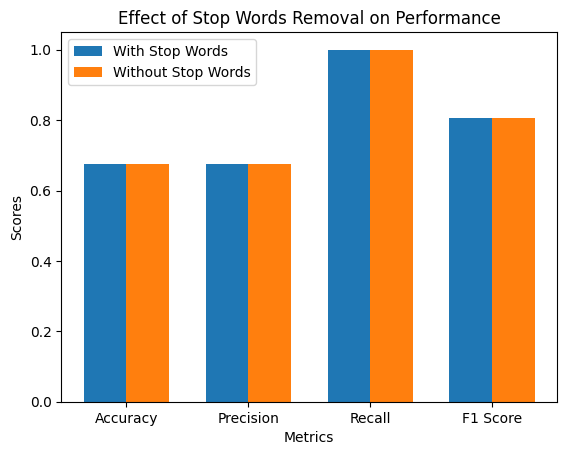


Training with words occurring more than 1000 times.

Training with words occurring more than 100 times.

Training with words occurring more than 50 times.

Threshold      Accuracy  Precision Recall    F1        
1000           0.6739    0.6739    1.0000    0.8052    
100            0.6739    0.6739    1.0000    0.8052    
50             0.6739    0.6739    1.0000    0.8052    


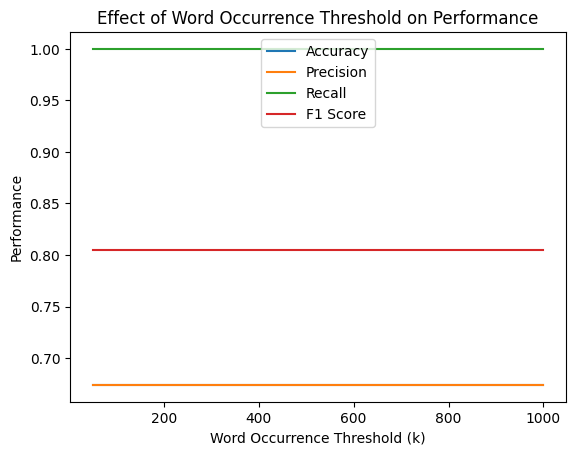


Training with Laplace smoothing (λ = 2.0)

Training with Laplace smoothing (λ = 1.0)

Training with Laplace smoothing (λ = 0.5)

Training with Laplace smoothing (λ = 0.1)

Training with Laplace smoothing (λ = 0.005)

Lambda    Accuracy  Precision Recall    F1        
2.0       0.6739    0.6739    1.0000    0.8052    
1.0       0.6739    0.6739    1.0000    0.8052    
0.5       0.6739    0.6739    1.0000    0.8052    
0.1       0.6739    0.6739    1.0000    0.8052    
0.005     0.6739    0.6739    1.0000    0.8052    


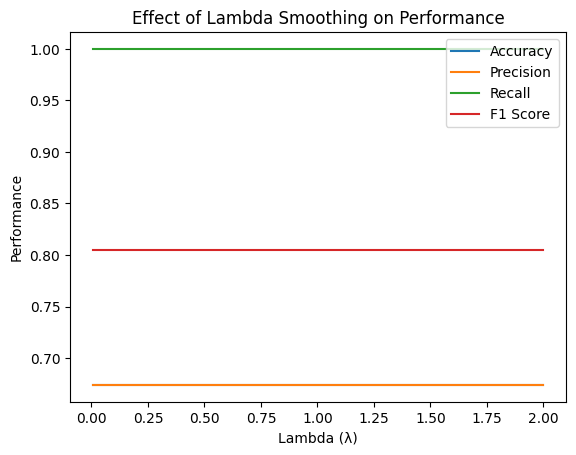

In [31]:

def experiment_stop_words(train_emails, train_labels, test_emails, test_labels, stop_words):
    # With stop words
    vocabulary_with_stop_words, ham_likelihood_with, spam_likelihood_with, prior_ham_with, prior_spam_with = train_naive_bayes(train_emails, train_labels, stop_words, alpha=1.0)
    y_pred_with = test_naive_bayes(test_emails, vocabulary_with_stop_words, ham_likelihood_with, spam_likelihood_with, prior_ham_with, prior_spam_with, stop_words)
    accuracy_with, precision_with, recall_with, f1_with = evaluate_classifier(test_labels, y_pred_with)

    # Without stop words
    vocabulary_without_stop_words, ham_likelihood_without, spam_likelihood_without, prior_ham_without, prior_spam_without = train_naive_bayes(train_emails, train_labels, [], alpha=1.0)
    y_pred_without = test_naive_bayes(test_emails, vocabulary_without_stop_words, ham_likelihood_without, spam_likelihood_without, prior_ham_without, prior_spam_without, [])
    accuracy_without, precision_without, recall_without, f1_without = evaluate_classifier(test_labels, y_pred_without)

    # Show results in a table or plot
    print("\nEffect of Stop Words Removal on Performance:")
    print(f"{'Metric':<15}{'With Stop Words':<20}{'Without Stop Words':<20}")
    print(f"{'Accuracy':<15}{accuracy_with:<20.4f}{accuracy_without:<20.4f}")
    print(f"{'Precision':<15}{precision_with:<20.4f}{precision_without:<20.4f}")
    print(f"{'Recall':<15}{recall_with:<20.4f}{recall_without:<20.4f}")
    print(f"{'F1 Score':<15}{f1_with:<20.4f}{f1_without:<20.4f}")

    # Show results as a bar chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    with_stop_words = [accuracy_with, precision_with, recall_with, f1_with]
    without_stop_words = [accuracy_without, precision_without, recall_without, f1_without]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, with_stop_words, width, label='With Stop Words')
    plt.bar(x + width/2, without_stop_words, width, label='Without Stop Words')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Effect of Stop Words Removal on Performance')
    plt.xticks(x, metrics)
    plt.legend(loc='best')
    plt.show()

def experiment_word_count_threshold(train_emails, train_labels, test_emails, test_labels, stop_words):
    thresholds = [1000, 100, 50]  # k > 1000, 100, 50
    results = []

    for threshold in thresholds:
        print(f"\nTraining with words occurring more than {threshold} times.")
        vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam = train_naive_bayes(train_emails, train_labels, stop_words, top_n_words=threshold)
        y_pred = test_naive_bayes(test_emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words)
        accuracy, precision, recall, f1 = evaluate_classifier(test_labels, y_pred)

        results.append((threshold, accuracy, precision, recall, f1))

    # Display results in a table format
    print(f"\n{'Threshold':<15}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1':<10}")
    for result in results:
        print(f"{result[0]:<15}{result[1]:<10.4f}{result[2]:<10.4f}{result[3]:<10.4f}{result[4]:<10.4f}")

    # Plotting results
    thresholds, accuracies, precisions, recalls, f1s = zip(*results)

    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1s, label='F1 Score')

    plt.xlabel('Word Occurrence Threshold (k)')
    plt.ylabel('Performance')
    plt.title('Effect of Word Occurrence Threshold on Performance')
    plt.legend(loc='best')
    plt.show()

def experiment_lambda_smoothing(train_emails, train_labels, test_emails, test_labels, stop_words):
    lambdas = [2.0, 1.0, 0.5, 0.1, 0.005]  # Different values of lambda (α)
    results = []

    for alpha in lambdas:
        print(f"\nTraining with Laplace smoothing (λ = {alpha})")
        vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam = train_naive_bayes(train_emails, train_labels, stop_words, alpha=alpha)
        y_pred = test_naive_bayes(test_emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words)
        accuracy, precision, recall, f1 = evaluate_classifier(test_labels, y_pred)

        results.append((alpha, accuracy, precision, recall, f1))

    # Display results in a table format
    print(f"\n{'Lambda':<10}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1':<10}")
    for result in results:
        print(f"{result[0]:<10}{result[1]:<10.4f}{result[2]:<10.4f}{result[3]:<10.4f}{result[4]:<10.4f}")

    #  Plotting results
    lambdas, accuracies, precisions, recalls, f1s = zip(*results)

    plt.plot(lambdas, accuracies, label='Accuracy')
    plt.plot(lambdas, precisions, label='Precision')
    plt.plot(lambdas, recalls, label='Recall')
    plt.plot(lambdas, f1s, label='F1 Score')

    plt.xlabel('Lambda (λ)')
    plt.ylabel('Performance')
    plt.title('Effect of Lambda Smoothing on Performance')
    plt.legend(loc='best')
    plt.show()


def experiment():
    label_file_path = '/content/drive/MyDrive/MP3/labels'
    stop_words_file = '/content/drive/MyDrive/MP3/stop_words.txt'  # Path to stop words file
    stop_words = load_stop_words(stop_words_file)

    # Load train and test labels
    train_ham_email_paths, train_spam_email_paths, test_ham_email_paths, test_spam_email_paths = load_labels(label_file_path)

    # Combine ham and spam for training
    train_emails = train_ham_email_paths + train_spam_email_paths
    train_labels = [0] * len(train_ham_email_paths) + [1] * len(train_spam_email_paths)
    print('Total amount of train emails:', len(train_emails))


    # Combine ham and spam for testing
    test_emails = test_ham_email_paths + test_spam_email_paths
    test_labels = [0] * len(test_ham_email_paths) + [1] * len(test_spam_email_paths)
    print('Total amount test emails:', len(test_emails))


    # Experiment 1: Effect of Stop Words
    experiment_stop_words(train_emails, train_labels, test_emails, test_labels, stop_words)

    # Experiment 2: Number of Words Used for Training (Word Occurrence Threshold)
    experiment_word_count_threshold(train_emails, train_labels, test_emails, test_labels, stop_words)

    # Experiment 3: Lambda Smoothing
    experiment_lambda_smoothing(train_emails, train_labels, test_emails, test_labels, stop_words)

experiment()

1. What is the effect of removing stop words in terms of precision, recall, and
accuracy? Show a plot or a table of these results.
It can be seen that the accuracy, precision and recall remain constant with or without removing the stop words. The removal of stop words did not change the performance of hhe model, indicating that the words included in the stop words may not be the significant basis for classification.

2. Experiment on the number of words used for training. Filter the dictionary to
include only words occurring more than k times (1000 words, then k > 100, and k
= 50 times). For example, the word “offer” appears 150 times, that means that it
will be included in the dictionary.
The performance remain constant in different thresh holds which that the selected words frequency did not add any additional value for the model. This indicates that the selected words may not be impactful for the data set.

3. Discuss the results of the different parameters used for Lambda smoothing. Test
it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate
performance metrics for each.
The lambda has shown similar performance on the model indicating that the model might be well calibrated to the training data. This implies that the model is resilient to changes in the smoothing parameter in this context.

4. What are your recommendations to further improve the model?
I might have an incorrect implementations since the I believe that including stop words and changing the dictionary filter should have an effect on the model's performance. Anyways, based on my limited knowledge the models the improvements that I could think of would be including more minority samples or generate spams to increase the robustness of the model. I also believe that there is a need to for emails to be processed better since the email in the dataset are mimes which made it harder to process and might lead to some loss.